<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/VAE_Linear_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from einops import rearrange
import time
import torch.nn.functional as F
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("mps")
print(torch.backends.mps.is_available(), torch.backends.mps.is_built(), device)

check_point_path = '/Users/bin.guanb/code/MachineL/model_state/VAE_CNN_MNIST'
epoch_cnt = 0
total_loss = []

True True mps


In [11]:
trans = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="/Users/bin.guanb/code/MachineL/dataset/", transform=trans, download=True, train=True) # 6W张图片, 10种分类
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(len(dataset.classes), len(dataset), image.shape) # 10; 6W; 100,1,28,28

trans_test = transforms.Compose([transforms.ToTensor()])
dataset_test = datasets.MNIST(root="/Users/bin.guanb/code/MachineL/dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
print(len(dataset_test))

10 60000 torch.Size([100, 1, 28, 28])
10000


In [12]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(28*28,256), nn.ReLU(), nn.Linear(256, 2*2))
    self.decoder = nn.Sequential(nn.Linear(2,256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid())

  def reparam(self, mean, logvar):
    epsilon = torch.randn_like(mean)
    return mean + epsilon * torch.exp(logvar/2)

  def kl_loss(self, mean, logvar):
    return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()

  def gen_loss(self, gen_img, img):
    return nn.BCELoss(size_average=False)(gen_img, img) / img.size(0)

  def forward(self, x):
    x = x.view(x.shape[0], -1) # ,28*28
    h = self.encoder(x) # ,2*2
    mean, logvar = h.chunk(2, dim=1) # ,2  + ,2
    h = self.reparam(mean, logvar) #,2
    out = self.decoder(h)
    out = rearrange(out, 'b (h w) -> b 1 h w', h=28)
    return out, mean, logvar

model = Net().to(device)
#print(model)
model_cpu = Net().to("cpu")
#summary(model_cpu, (28,28))
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

if os.path.exists(check_point_path):
  checkpoint = torch.load(check_point_path)
  model.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optimizer_state'])
  epoch_cnt = checkpoint['epoch_cnt']
  total_loss = checkpoint['total_loss']

epoch:219 loss:144.65 time:5.1


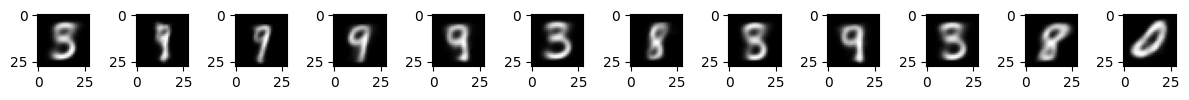

epoch:229 loss:144.40 time:5.5


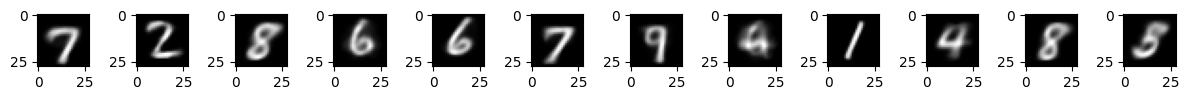

epoch:239 loss:144.17 time:5.5


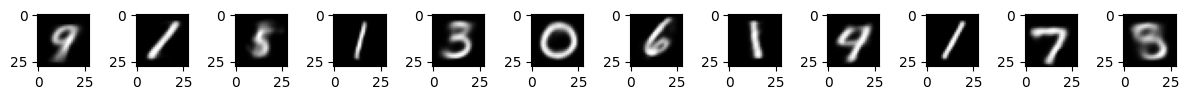

epoch:249 loss:143.95 time:5.5


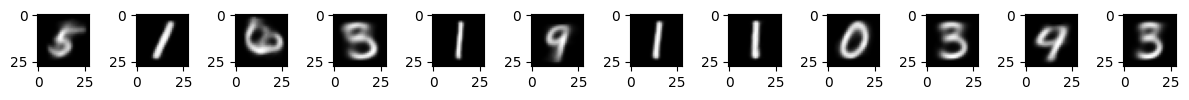

epoch:259 loss:143.72 time:5.2


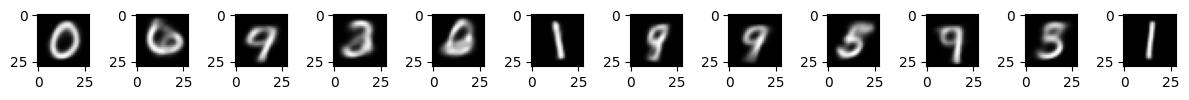

epoch:269 loss:143.53 time:5.1


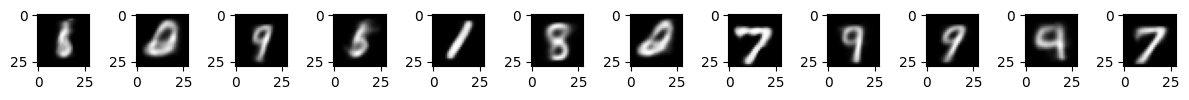

epoch:279 loss:143.33 time:5.1


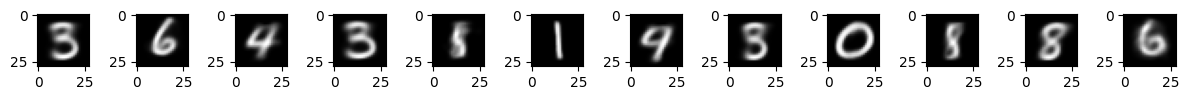

epoch:289 loss:143.17 time:5.4


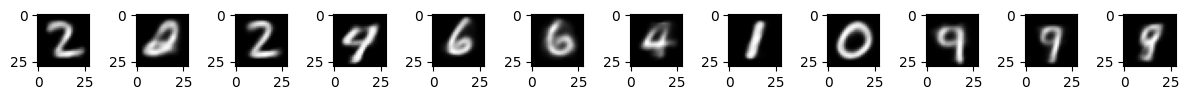

epoch:299 loss:142.98 time:5.2


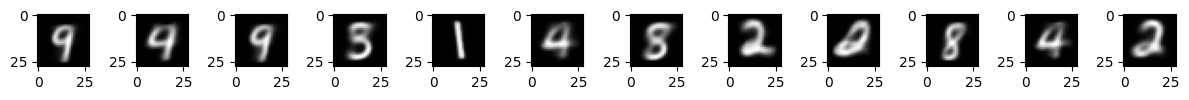

epoch:309 loss:142.81 time:5.1


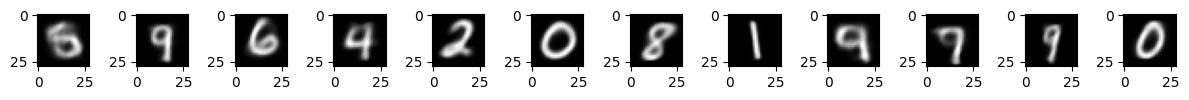

epoch:319 loss:142.65 time:5.1


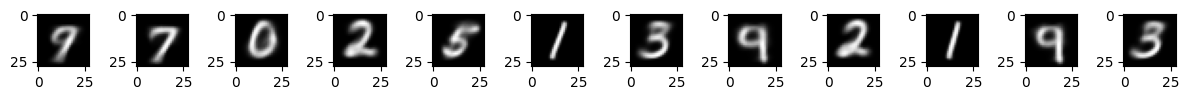

epoch:329 loss:142.49 time:5.1


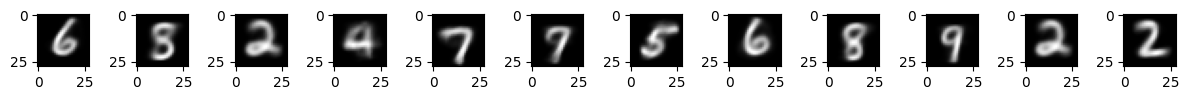

epoch:339 loss:142.34 time:5.2


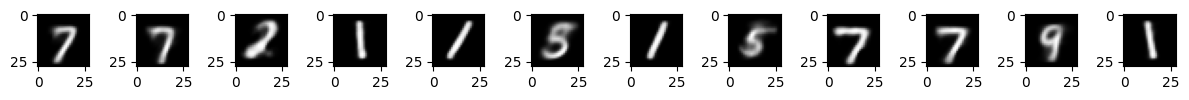

epoch:349 loss:142.21 time:5.5


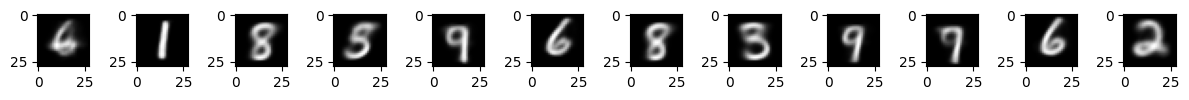

epoch:359 loss:142.07 time:5.3


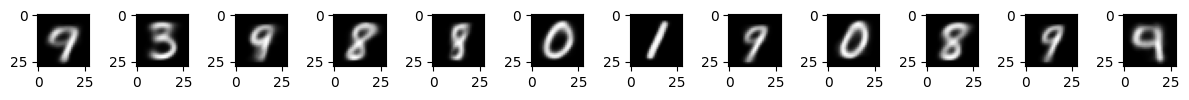

epoch:369 loss:141.94 time:5.3


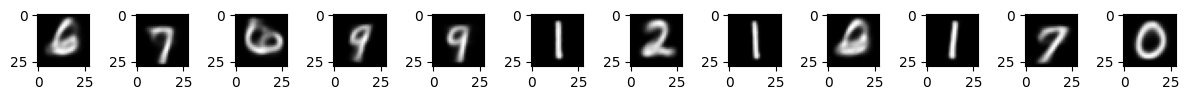

epoch:379 loss:141.78 time:5.2


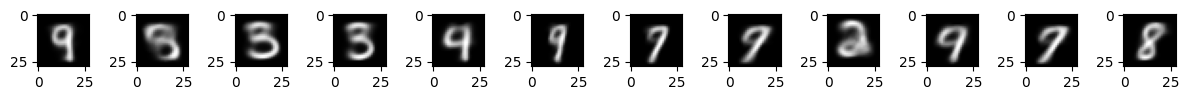

epoch:389 loss:141.67 time:5.2


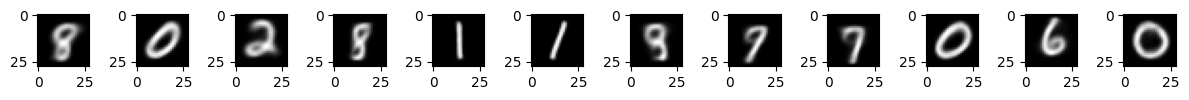

epoch:399 loss:141.57 time:5.1


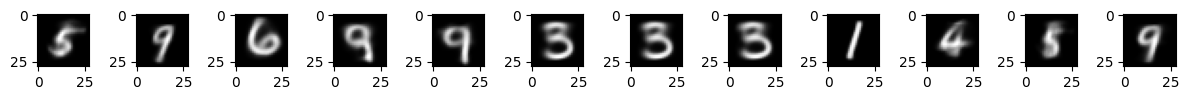

epoch:409 loss:141.44 time:5.1


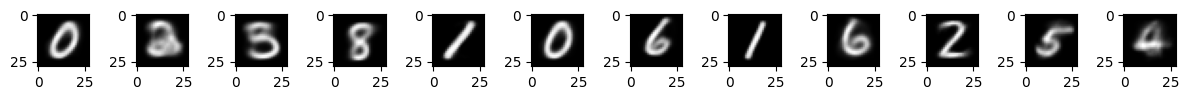

epoch:419 loss:141.32 time:5.1


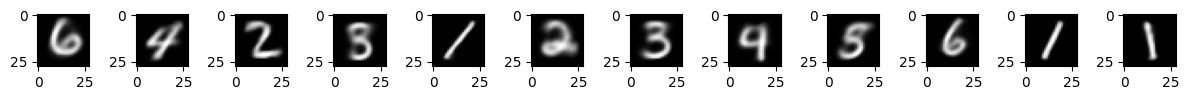

epoch:429 loss:141.21 time:5.1


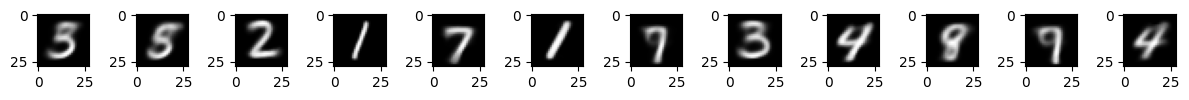

epoch:439 loss:141.09 time:5.1


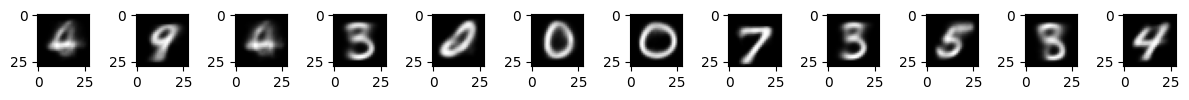

epoch:449 loss:141.01 time:5.2


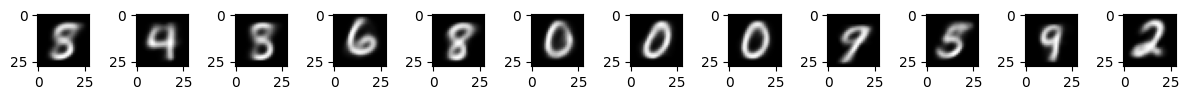

epoch:459 loss:140.90 time:5.2


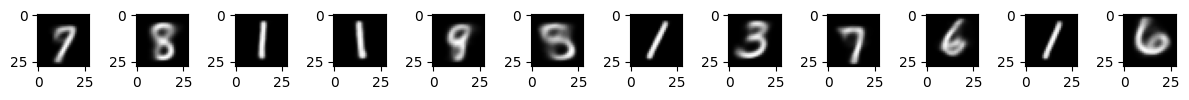

epoch:469 loss:140.83 time:5.2


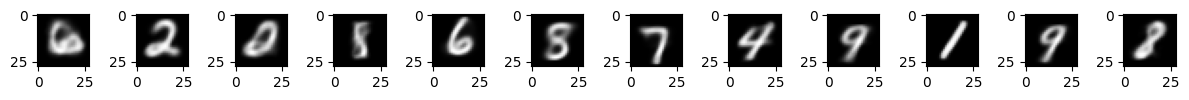

epoch:479 loss:140.71 time:5.1


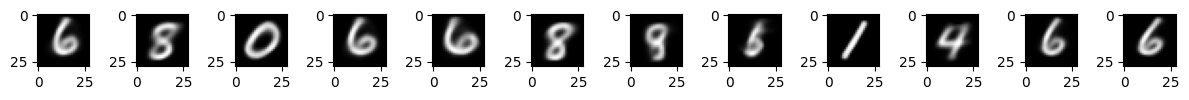

epoch:489 loss:140.60 time:5.1


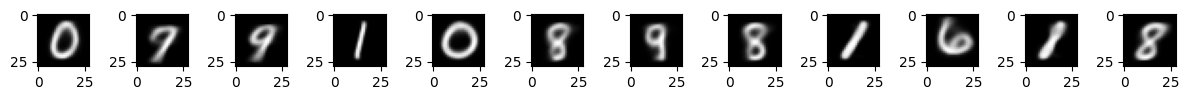

epoch:499 loss:140.50 time:5.2


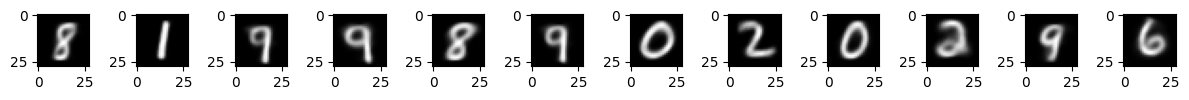

epoch:509 loss:140.41 time:5.1


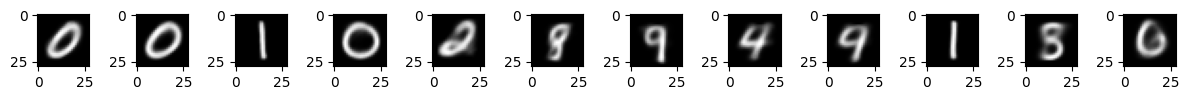

In [13]:
for oneRound in range(1,300):
  epoch_loss = []
  startTime = time.time()
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    gen_img, mean, logvar = model(img)

    loss = model.gen_loss(gen_img, img) + model.kl_loss(mean, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss.append(loss.item())

  epoch_cnt += 1
  total_loss.append(np.mean(epoch_loss))
  costTime = time.time() - startTime

  if epoch_cnt % 10 == 9:
    print("epoch:{} loss:{:.2f} time:{:.1f}".format(
           epoch_cnt, np.mean(epoch_loss), costTime))
    with torch.no_grad():
      fig, axs = plt.subplots(1, 12, figsize=(12, 1))
      for i, ax in enumerate(axs.flatten()):
        ax.imshow(gen_img[i][0].cpu(), cmap='gray')
      plt.tight_layout()
      plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


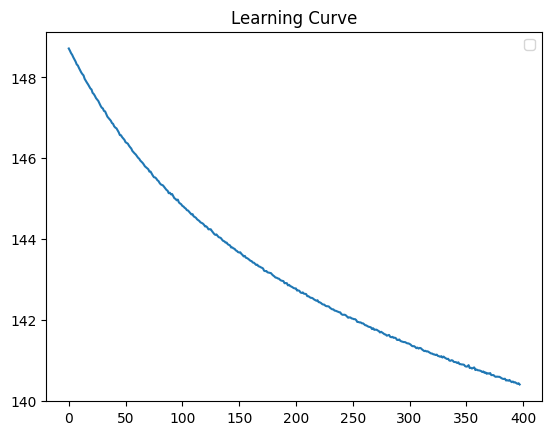

In [14]:
checkpoint = {
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'epoch_cnt' : epoch_cnt,
    'total_loss' : total_loss
}
torch.save(checkpoint, check_point_path)

plt.plot(total_loss)
plt.title("Learning Curve")
plt.legend();

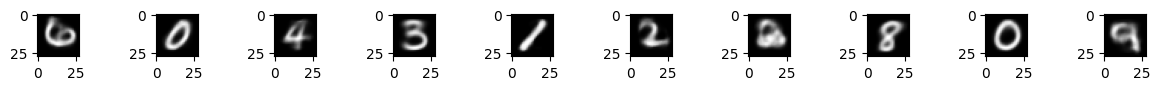

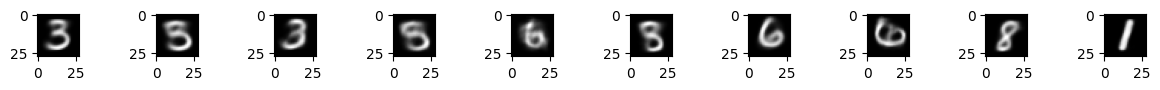

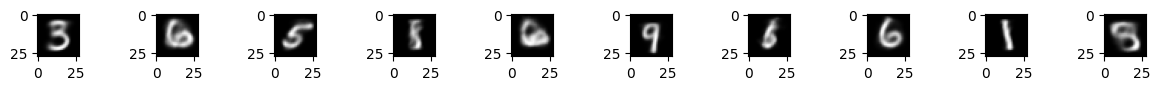

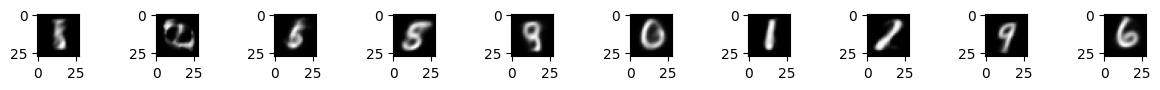

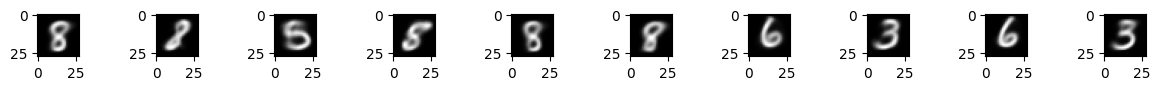

In [17]:
with torch.no_grad():
  for i in range(1,6):
    test = torch.randn(10,2).to(device)
    gen_img = model.decoder(test) # 10,28*28
    gen_img = rearrange(gen_img, 'b (h w) -> b 1 h w', h=28)

    fig, axs = plt.subplots(1, 10, figsize=(12, 1))
    for i, ax in enumerate(axs.flatten()):
      ax.imshow(gen_img[i][0].cpu(), cmap='gray')
    plt.tight_layout()
    plt.show()